In [1]:
import pandas as pd

# Load CSV files
df_labels = pd.read_csv("actual.csv")
df_expr1 = pd.read_csv("data_set_ALL_AML_independent.csv")
df_expr2 = pd.read_csv("data_set_ALL_AML_train.csv")


In [5]:
df_labels['cancer'].unique()

array(['ALL', 'AML'], dtype=object)

In [8]:
df_expr1.shape

(7129, 70)

In [9]:
df_expr2.shape

(7129, 78)

In [10]:
# Function to extract expression columns only (skip "call" and metadata)
def extract_expression_matrix(df):
    df_clean = df.drop(columns=["Gene Description", "Gene Accession Number"])
    value_cols = [col for col in df_clean.columns if not str(col).startswith("call")]
    return df_clean[value_cols]

# Apply to both files
expr1 = extract_expression_matrix(df_expr1)
expr2 = extract_expression_matrix(df_expr2)

# Combine both (same rows, more columns → patients)
expr_combined = pd.concat([expr1, expr2], axis=1)

# Transpose so each row = patient, columns = gene features
X = expr_combined.T.reset_index(drop=True)
X['label'] = df_labels['cancer'].astype('category').values


In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,label
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,1023,67,214,-135,1074,475,48,168,-70,ALL
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,529,-295,352,-67,67,263,-33,-33,-21,ALL
2,22,-153,17,276,-211,-250,55,-141,0,500,...,399,16,558,24,893,297,6,1971,-42,ALL
3,-243,-218,-163,182,-289,-268,-285,-172,52,-134,...,277,6,81,2,722,170,0,510,-73,ALL
4,-130,-177,-28,266,-170,-326,-222,-93,10,159,...,643,51,450,-46,612,370,29,333,-19,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,15,-114,2,193,-51,-155,29,-105,42,524,...,492,54,277,-13,279,51,6,2484,-2,ALL
68,-318,-192,-95,312,-139,-344,324,-237,105,167,...,737,63,472,33,737,227,-9,371,-31,ALL
69,-32,-49,49,230,-367,-508,-349,-194,34,-56,...,592,57,215,-22,588,361,-26,133,-32,ALL
70,-124,-79,-37,330,-188,-423,-31,-223,-82,176,...,938,-15,433,-2,1170,284,39,298,-3,ALL


In [12]:
from sklearn.preprocessing import StandardScaler

# Separate features and labels
features = X.drop(columns=['label'])
labels = X['label']

# Z-score normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


Original shape: (72, 7129), Reduced shape: (72, 60)


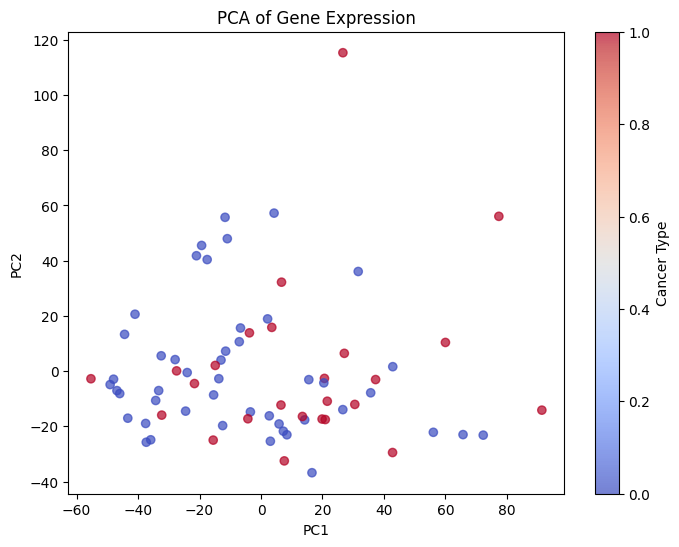

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {X_scaled.shape}, Reduced shape: {X_pca.shape}")

# Optional: Plot first 2 PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels.cat.codes, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Gene Expression')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cancer Type')
plt.show()


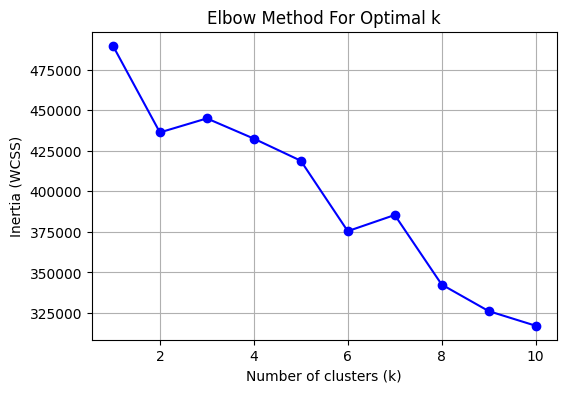

In [14]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [15]:
# From elbow plot, assume optimal k = 2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels to DataFrame
X_clustered = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
X_clustered['true_label'] = labels.values
X_clustered['cluster'] = clusters


In [16]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Clustering quality
ari = adjusted_rand_score(labels.cat.codes, clusters)
sil_score = silhouette_score(X_pca, clusters)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Silhouette Score: {sil_score:.3f}")


Adjusted Rand Index (ARI): 0.034
Silhouette Score: 0.116


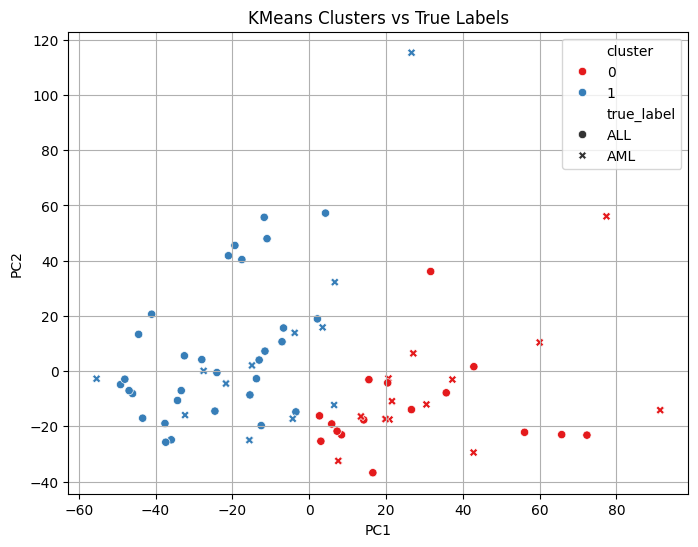

In [17]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_clustered, x='PC1', y='PC2', hue='cluster', style='true_label', palette='Set1')
plt.title('KMeans Clusters vs True Labels')
plt.grid(True)
plt.show()
